In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=f74d9a47b3dfb57ad2833d06c56c52a4ede9b8af17731d59ea35db5cbf65c809
  Stored in directory: /root/.cache/pip/wheels/77/bf/4c/b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built filterpy


## Task Logic

In [3]:
state_space = np.arange(0, 300)

def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k*(x - x0)))


def q(tau, method="HI"):
  if method == "HI":
    return np.random.binomial(n=1, p=0.1)
  if method == "HD":
    return np.random.binomial(n=1, p=sigmoid(tau, x0=10))


def g(s, state_space_size=300):
  # return x_t
  return np.random.triangular(np.maximum(s-20, 0),
                              s, np.minimum(s+20, state_space_size))


def a(s, state_space_size=300):
  # return s_t+1
  left_or_right = np.random.binomial(n=1, p=0.5)
  if left_or_right == 0:
    s_new = s - 25
    s_new = np.maximum(s_new, 0)
  else:
    s_new = s + 25
    s_new = np.minimum(s_new, state_space_size)
  return np.random.triangular(np.maximum(s_new-20, 0),
                              s_new,
                              np.minimum(s_new+20, state_space_size))




In [4]:
def simulate_snowballs(total_run_length=200, q_method="HI"):
  s_init = 150

  x_ts = []
  tau_ts = []
  s_ts = []
  s_t = s_init
  tau = 0
  for t in range(0, total_run_length):
    s_ts.append(s_t)
    # Save x and tau
    x_t = g(s_t)
    x_ts.append(x_t)
    tau_ts.append(tau)

    # Prepare for next time step
    if q(tau, method=q_method):
      tau = 0
      s_t = a(s_t)
    else:
      tau += 1

  return np.array(s_ts), np.array(x_ts), np.array(tau_ts)



## Plotting functions

In [5]:
def axplot_data(s_ts, x_ts, tau_ts, ax=None):
  if ax is None:
    plt.gca()

  ax.plot(s_ts, color="black")#, label=r"$s$")
  ax.scatter(range(0, total_run_length), x_ts, s=2.9, color="black")
  for idx in np.where(tau_ts == 0)[0]:
    ax.axvline(x=idx, color='grey', linestyle='--', alpha=0.6)
  ax.bar(range(total_run_length), tau_ts, alpha=0.3, color="green")
  ax.set_ylim([0, 300])
  ax.set_xlabel("time")
  ax.set_ylabel("position")

  return ax


def rolling_mean_model(x_ts, window_size=5):
  rolling_mean = pd.Series(x_ts).rolling(window=window_size).mean()
  rolling_std = pd.Series(x_ts).rolling(window=window_size).std()

  return rolling_mean, rolling_std


def axplot_est_with_uncert(estimate, uncertainty=None, window_size=5, ax=None, label=None):
  if ax is None:
    plt.gca()


  ax.plot(estimate, color="red", label=label)
  if uncertainty is not None:
    ax.fill_between(range(0, len(estimate)),
                  estimate - uncertainty,
                  estimate + uncertainty,
                  color="red", alpha=0.2,)# label="±1 Std Dev")

  return ax


## Data Analysis Functions

In [51]:
# Three evaluation metrics

# 1.
def calc_learning_rate(s_ts, x_ts):
  """Calculate learning rates as in the paper."""
  rates = []
  for t in range(len(s_ts)-1):
    if x_ts[t+1] == s_ts[t]:
      rates.append(0)
    else:
      rate = (s_ts[t+1] - s_ts[t]) / (x_ts[t+1] - s_ts[t])
      rates.append(rate)

  return np.array(rates)

# 2.
def calc_repetition_propensity(s_ts):
  """Calculate repetition propensity as in the paper."""
  propensities = []
  for t in range(len(s_ts)-1):
    if s_ts[t+1] == s_ts[t]:
      propensities.append(1)
    else:
      propensities.append(0)

  return np.array(propensities)

# 3. standard deviation



In [7]:
def segment_by_tau(s_ts, tau_ts, tau_range=(4, 8)):
    """Segment s_ts into chunks based on run-length resets in tau_ts.

    Args:
        s_ts : array-like
            Sequence of states/choices.
        tau_ts : array-like
            Sequence of tau values (same length as s_ts).
        tau_range : tuple (start, end), optional
            Interval of segment indices to extract. If None, returns full segments.

    Returns:
        list of np.ndarray : Segmented subsequences of s_ts.
    """
    segments = []
    start_idx = None

    for i in range(len(tau_ts)):
        if tau_ts[i] == 0:
            if start_idx is not None:
                segments.append(s_ts[start_idx:i])
            start_idx = i

    # Add last segment
    if start_idx is not None:
        segments.append(s_ts[start_idx:])

    if tau_range is not None:
        start, end = tau_range
        # Filter for segments that have enough points for the given tau_range
        return [
            seg[start:end+1]
            for seg in segments
            if len(seg) >= end+1 and len(seg[start:end+1]) >= 2  # Ensure segment length after slicing is at least 2
        ]

    return segments

In [8]:
def flatten_singletons(lst):
    """Flatten a list of singleton lists to a 1D list/array; leave others unchanged."""
    # Check if all elements are list/array with length 1
    if all(isinstance(x, (list, np.ndarray)) and len(x) == 1 for x in lst):
        return np.array(lst).ravel().tolist()  # flatten
    return lst  # leave unchanged


def eval_learning_rates(s_ts, x_ts, tau_ts, tau_range=(1,2)):
    """Segment s_ts and x_ts by tau, then compute learning rates.

    Args:
        s_ts : array-like
            Sequence of choices/states (e.g., rolling mean).
        x_ts : array-like
            Sequence of x values (e.g., true targets).
        tau_ts : array-like
            Sequence of tau values (same length as s_ts and x_ts).
        tau_range : tuple of int, optional
            Range (start, end) of indices to slice within each segment.

    Returns:
        list of np.ndarray
            Each element is an array of learning rates for one segment.
    """
    # segment both sequences
    s_segments = segment_by_tau(s_ts, tau_ts, tau_range)
    x_segments = segment_by_tau(x_ts, tau_ts, tau_range)

    # compute learning rates per segment
    learning_rates = [calc_learning_rate(s, x) for s, x in zip(s_segments, x_segments)]

    learning_rates = flatten_singletons(learning_rates)

    return learning_rates



# Models

## Kalman Filter Model

In [9]:
#!pip install filterpy

In [10]:
def kalman_filter_model(x_ts):
  import filterpy
  from filterpy.kalman import KalmanFilter
  kf = KalmanFilter(dim_x=1, dim_z=1)
  kf.x = np.array([[0.]])      # initial state estimate
  kf.F = np.array([[1.]])      # state transition matrix
  kf.H = np.array([[1.]])      # measurement function
  kf.P = np.array([[100]])      # initial uncertainty
  kf.R = np.array([[0.1]])     # measurement noise
  kf.Q = np.array([[1e-1]])    # process noise

  # Run filter
  estimates = []
  std_devs = []

  for z in x_ts:
      kf.predict()
      kf.update(z)
      estimates.append(kf.x[0, 0])
      std_devs.append(np.sqrt(kf.P[0, 0]))  # standard deviation

  # Convert to arrays
  estimates = np.array(estimates)
  std_devs = np.array(std_devs)

  return estimates, std_devs


## Optimal Model

In [11]:
import numpy as np

S = 300
states = np.arange(S)

def triangular_pmf_on_grid(center, halfwidth=20, S=300):
    """Discrete triangular PMF on integers around `center`, clipped to [0,S-1]."""
    lo = max(0, center - halfwidth)
    hi = min(S-1, center + halfwidth)
    xs = np.arange(lo, hi + 1)
    w = (halfwidth - np.abs(xs - center)).astype(float)
    w[w < 0] = 0.0
    pmf = np.zeros(S, float)
    s = w.sum()
    if s > 0:
        pmf[xs] = w / s
    return pmf  # shape (S,)

# ------------- build tables (one-time) -------------
def build_L_table(S=300, halfwidth=20):
    """L_table[s, x_bin] = p(x_bin | s)."""
    L = np.zeros((S, S), float)
    for s in range(S):
        pmf = triangular_pmf_on_grid(s, halfwidth, S)
        L[s, :] = pmf
    return L  # rows sum to 1

def build_A(S=300, hop=25, halfwidth=20):
    """
    A[s_prev, s] = p(s | change from s_prev).
    50% hop left (s_prev-hop), 50% hop right (s_prev+hop), each blurred triangularly.
    """
    A = np.zeros((S, S), float)
    for s_prev in range(S):
        left_c  = max(0, s_prev - hop)
        right_c = min(S-1, s_prev + hop)
        pmf_left  = triangular_pmf_on_grid(left_c,  halfwidth, S)
        pmf_right = triangular_pmf_on_grid(right_c, halfwidth, S)
        A[s_prev, :] = 0.5 * pmf_left + 0.5 * pmf_right  # already normalized
    return A

def build_Q_sigmoid(TAU_MAX=25, lam=1.0, Tmean=10.0):
    """
    HD hazard q(τ) = 1 / (1 + exp(-lam * (τ - Tmean))).
    lam  = λ (slope), Tmean = T (controls where hazard rises).
    Returns Q of shape (TAU_MAX+1,)
    """
    taus = np.arange(TAU_MAX+1, dtype=float)
    return 1.0 / (1.0 + np.exp(-lam * (taus - Tmean)))

def make_T(A, q):
    """HI transition: T = (1-q) I + q A."""
    S = A.shape[0]
    return (1.0 - q) * np.eye(S) + q * A

# ------------- online update (HI) -------------
def g_like_from_table(x_obs, L_table):
    xi = int(np.clip(round(x_obs), 0, L_table.shape[1]-1))
    return L_table[:, xi]  # vector length S

def optimal_update_HI(p_prev, x_obs, T, L_table):
    # predict
    p_pred = p_prev @ T                       # (S,)
    # update with likelihood
    L = g_like_from_table(x_obs, L_table)     # (S,)
    p_post = L * p_pred
    Z = p_post.sum()
    return p_post / Z if Z > 0 else np.ones_like(p_post)/len(p_post)

def run_ideal_observer_HI(xs, q=0.10, S=300, hop=25, halfwidth=20):
    """
    xs : list/array of observed dots (int/float, will be rounded to 0..S-1)
    returns: posteriors [T x S] and MAP estimates [T]
    """
    L_table = build_L_table(S, halfwidth)
    A = build_A(S, hop, halfwidth)
    T = make_T(A, q)

    p = np.ones(S) / S  # uniform prior
    posts = []
    maps = []
    means = []
    stds = []
    state_vals = np.arange(S)
    for x in xs:
        p = optimal_update_HI(p, x, T, L_table)
        posts.append(p)
        maps.append(int(np.argmax(p)))  # MAP (optimal under 0–1 loss)

        # Uncertainty estimates
        mu = np.sum(p * state_vals)
        sigma = np.sqrt(np.sum(p * (state_vals - mu)**2))
        means.append(mu)
        stds.append(sigma)
    #return np.vstack(posts), np.array(maps)
    return np.vstack(posts), np.array(maps), np.array(means), np.array(stds)

def optimal_update_HD(P_prev, x_obs, A, L_table, Q):
    """
    P_prev : (S, TAU_MAX+1)
    A      : (S,S)
    L_table: (S,S)
    Q      : (TAU_MAX+1,)
    """
    S, Tm1 = P_prev.shape
    TAU_MAX = Tm1 - 1

    # likelihood over s for this x
    L = g_like_from_table(x_obs, L_table)  # (S,)

    # --- change branch -> tau = 0 ---
    # mass leaving each (s_prev, tau_prev) via hazard Q[tau_prev]
    change_mass_sprev = (P_prev * Q[None, :]).sum(axis=1)        # (S,)
    CH0 = A.T @ change_mass_sprev                                 # (S,)
    CH = np.zeros_like(P_prev)                                     # (S, TAU_MAX+1)
    CH[:, 0] = CH0

    # --- no-change branch -> shift tau by +1, keep s ---
    NC = np.zeros_like(P_prev)
    # for tau >= 1: comes from previous tau-1 with factor (1 - Q[tau-1])
    NC[:, 1:] = P_prev[:, :-1] * (1.0 - Q[:-1])[None, :]

    # --- combine branches and apply likelihood ---
    P_post = (NC + CH) * L[:, None]

    # normalize
    Z = P_post.sum()
    if Z <= 0:
        P_post[:] = 1.0 / P_post.size
    else:
        P_post /= Z
    return P_post

def run_ideal_observer_HD(xs, lam=1.0, Tmean=10.0, TAU_MAX=25,
                          S=300, hop=25, halfwidth=20):
    """
    xs      : sequence of observed dots (int or float)
    lam,Tmean : hazard parameters (λ, T) for HD
    TAU_MAX : max run-length tracked
    Returns: posts_s (T×S), map_est (T,), means (T,), stds (T,)
    """
    L_table = build_L_table(S, halfwidth)
    A = build_A(S, hop, halfwidth)
    Q = build_Q_sigmoid(TAU_MAX, lam, Tmean)

    # start uniform over (s, τ)
    P = np.ones((S, TAU_MAX+1), dtype=float)
    P /= P.sum()

    posts_s, maps, means, stds = [], [], [], []
    state_vals = np.arange(S)

    for x in xs:
        # update joint (s,τ)
        P = optimal_update_HD(P, x, A, L_table, Q)

        # get state marginal
        p_s = P.sum(axis=1)                       # (S,)
        posts_s.append(p_s)
        maps.append(int(np.argmax(p_s)))

        mu = np.sum(p_s * state_vals)
        sigma = np.sqrt(np.sum(p_s * (state_vals - mu)**2))
        means.append(mu); stds.append(sigma)

    return np.vstack(posts_s), np.array(maps), np.array(means), np.array(stds)

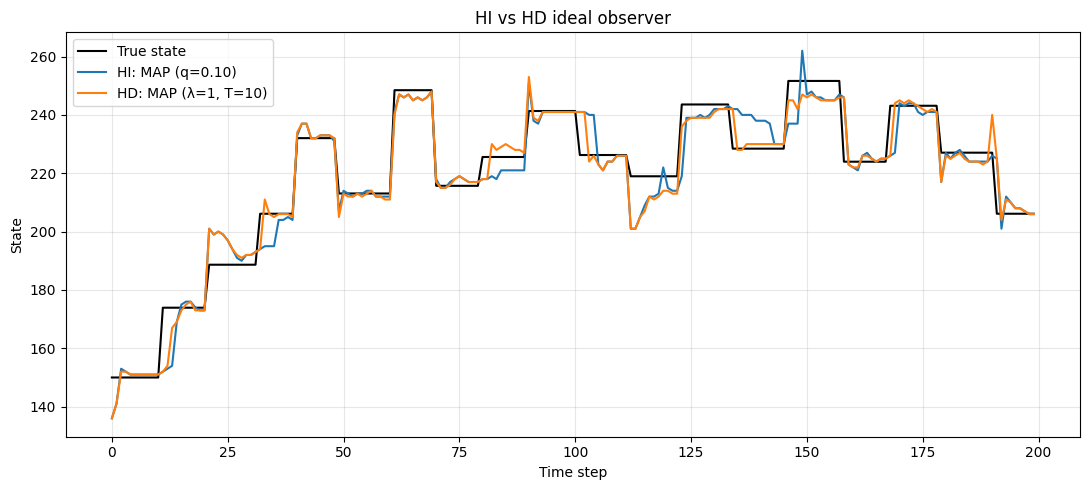

In [12]:
# simulate (your existing simulator; for a fair HD test you can switch it to HD later)
s_true, x_obs, tau_true = simulate_snowballs(total_run_length=200, q_method="HD")

# HI (optimal with q=0.10)
posts_HI, map_HI, mean_HI, std_HI = run_ideal_observer_HI(x_obs, q=0.10)

# HD (λ=1, T=10 per paper defaults)
posts_HD, map_HD, mean_HD, std_HD = run_ideal_observer_HD(x_obs, lam=1.0, Tmean=10.0, TAU_MAX=25)

# plot
import matplotlib.pyplot as plt
t = np.arange(len(x_obs))
plt.figure(figsize=(11,5))
plt.plot(s_true, color='black', linewidth=1.5, label="True state")

plt.plot(map_HI, color='tab:blue', label="HI: MAP (q=0.10)")

plt.plot(map_HD, color='tab:orange', label="HD: MAP (λ=1, T=10)")

plt.xlabel("Time step"); plt.ylabel("State")
plt.title("HI vs HD ideal observer")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


# Evaluate Data and Models

In [13]:
## Plot full run

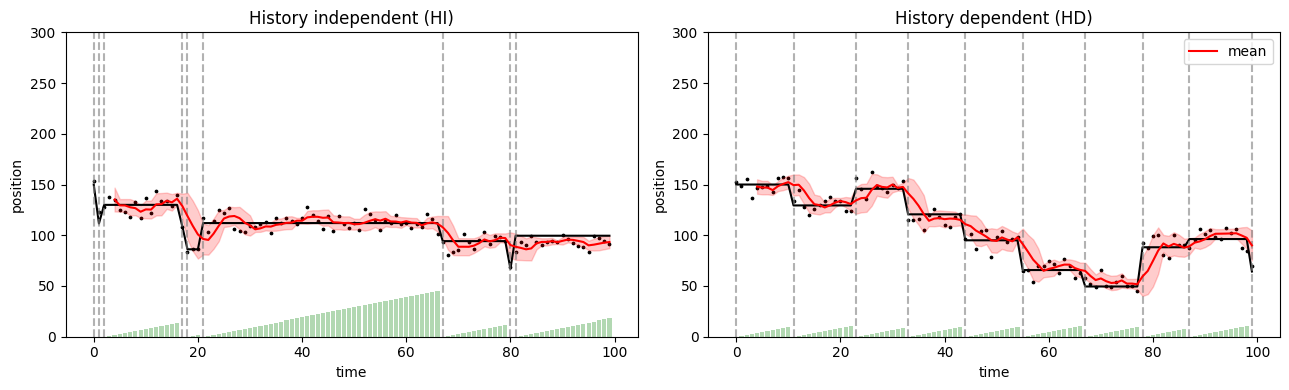

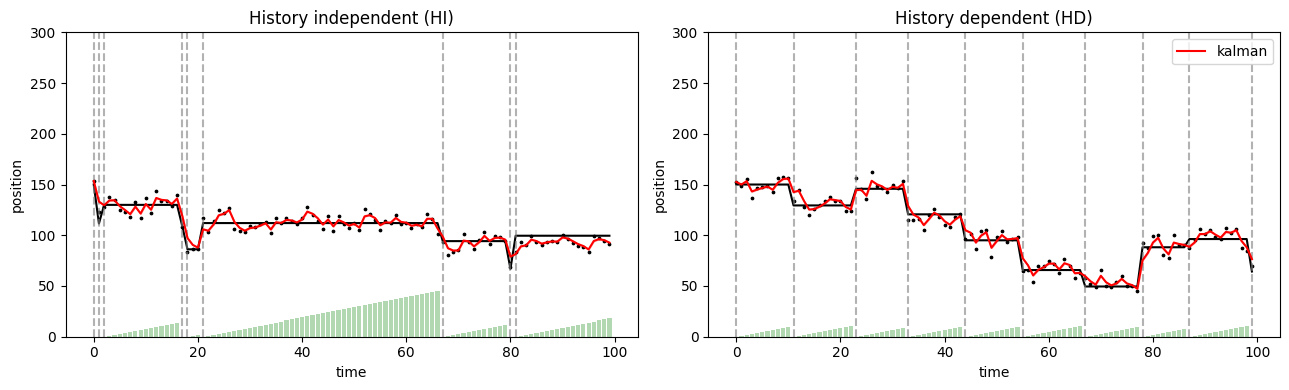

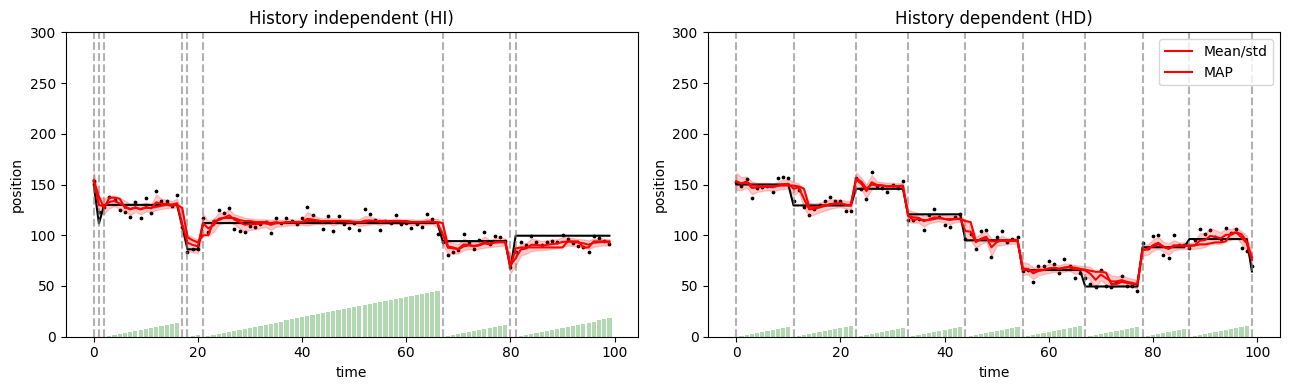

In [14]:
#np.random.seed(100)

total_run_length = 100
s_ts_hi, x_ts_hi, tau_ts_hi = simulate_snowballs(total_run_length, q_method="HI")
s_ts_hd, x_ts_hd, tau_ts_hd = simulate_snowballs(total_run_length, q_method="HD")


# Running mean model
fig, axs = plt.subplots(1,2, figsize=(13, 4))
axs[0].set_title("History independent (HI)")
axplot_data(s_ts_hi, x_ts_hi, tau_ts_hi, ax=axs[0])
rolling_mean_hi, rolling_std_hi = rolling_mean_model(x_ts_hi)
axplot_est_with_uncert(rolling_mean_hi, rolling_std_hi, ax=axs[0])

axs[1].set_title("History dependent (HD)")
axplot_data(s_ts_hd, x_ts_hd, tau_ts_hd, ax=axs[1])
rolling_mean_hd, rolling_std_hd = rolling_mean_model(x_ts_hd)
axplot_est_with_uncert(rolling_mean_hd, rolling_std_hd, ax=axs[1], label="mean")
axs[1].legend()
fig.tight_layout()

# Kalman fitler model
fig, axs = plt.subplots(1,2, figsize=(13, 4))
axs[0].set_title("History independent (HI)")
axplot_data(s_ts_hi, x_ts_hi, tau_ts_hi, ax=axs[0])
kalman_mean_hi, kalman_std_hi = kalman_filter_model(x_ts_hi)
axplot_est_with_uncert(kalman_mean_hi, kalman_std_hi, ax=axs[0])

axs[1].set_title("History dependent (HD)")
axplot_data(s_ts_hd, x_ts_hd, tau_ts_hd, ax=axs[1])
kalman_mean_hd, kalman_std_hd = kalman_filter_model(x_ts_hd)
axplot_est_with_uncert(kalman_mean_hd, kalman_std_hd, ax=axs[1], label="kalman")
axs[1].legend()
fig.tight_layout()

# Ideal Observer with known likelihood (triangular-shape) and fixed jump distance (25)
fig, axs = plt.subplots(1,2, figsize=(13, 4))
axs[0].set_title("History independent (HI)")
axplot_data(s_ts_hi, x_ts_hi, tau_ts_hi, ax=axs[0])
posts, map_est, means, stds = run_ideal_observer_HI(x_ts_hi, q=0.10)
axplot_est_with_uncert(means, stds, ax=axs[0], label="Mean/std")
axplot_est_with_uncert(map_est, None, ax=axs[0])

axs[1].set_title("History dependent (HD)")
axplot_data(s_ts_hd, x_ts_hd, tau_ts_hd, ax=axs[1])
posts, map_est, means, stds = run_ideal_observer_HI(x_ts_hd, q=0.10)
axplot_est_with_uncert(means, stds, ax=axs[1], label="Mean/std")
axplot_est_with_uncert(map_est, None, ax=axs[1], label="MAP")
axs[1].legend()
fig.tight_layout()

## Plot learning rates

In [35]:
from pathlib import Path

# Read data
hi_path = Path("./hi_data")
hd_path = Path("./hd_data")

hi_files = hi_path.glob("*.csv")
hd_files = hd_path.glob("*.csv")

dfs_hi = [pd.read_csv(f) for f in hi_files]
dfs_hd = [pd.read_csv(f) for f in hd_files]

hi_df = pd.concat(dfs_hi, ignore_index=True)
hd_df = pd.concat(dfs_hd, ignore_index=True)

# Exclude practice trials
#hi_df = hi_df.query("tutorial_phase.isna()")
#hd_df = hd_df.query("tutorial_phase.isna()")


In [36]:
# Number participants
len(hi_df["participantID"].unique()), len(hd_df["participantID"].unique())

(5, 5)

In [37]:
# Participant ranking
pd.concat([
    hi_df.groupby("participantID")["score_total_at_checkpoint"].max(),
    hd_df.groupby("participantID")["score_total_at_checkpoint"].max()
]).sort_values(ascending=False)


,score_total_at_checkpoint
participantID,
P19214,93539
P89618,52088
P33828,50968
P54381,49871
P65604,47421
P61945,46803
P46095,46318
P22549,44983
P93254,43929


In [38]:
lr_df_participants_early = compare_learning_rates_hi_hd(
    s_ts_hi, x_ts_hi, tau_ts_hi,
    s_ts_hd, x_ts_hd, tau_ts_hd,
    tau_range=(5,6)
    )
lr_df_participants_late = compare_learning_rates_hi_hd(
    s_ts_hi, x_ts_hi, tau_ts_hi,
    s_ts_hd, x_ts_hd, tau_ts_hd,
    tau_range=(9, 10)
    )
lr_df_mean_early = compare_learning_rates_hi_hd(
    rolling_mean_hd.to_numpy(), x_ts_hi, tau_ts_hi,
    rolling_mean_hi.to_numpy(), x_ts_hd, tau_ts_hd,
    tau_range=(5,6)
    )
lr_df_mean_late = compare_learning_rates_hi_hd(
    rolling_mean_hd.to_numpy(), x_ts_hi, tau_ts_hi,
    rolling_mean_hi.to_numpy(), x_ts_hd, tau_ts_hd,
    tau_range=(9,10)
    )
lr_df_bayes_early = compare_learning_rates_hi_hd(
    map_est_hi, x_ts_hi, tau_ts_hi,
    map_est_hd, x_ts_hd, tau_ts_hd,
    tau_range=(5,6)
    )
lr_df_bayes_late = compare_learning_rates_hi_hd(
    map_est_hi, x_ts_hi, tau_ts_hi,
    map_est_hd, x_ts_hd, tau_ts_hd,
    tau_range=(9,10)
    )
lr_df_bayes_HD_early = compare_learning_rates_hi_hd(
    map_est_HD_hi, x_ts_hi, tau_ts_hi,
    map_est_HD_hd, x_ts_hd, tau_ts_hd,
    tau_range=(5,6)
    )
lr_df_bayes_HD_late = compare_learning_rates_hi_hd(
    map_est_HD_hi, x_ts_hi, tau_ts_hi,
    map_est_HD_hd, x_ts_hd, tau_ts_hd,
    tau_range=(9,10)
    )

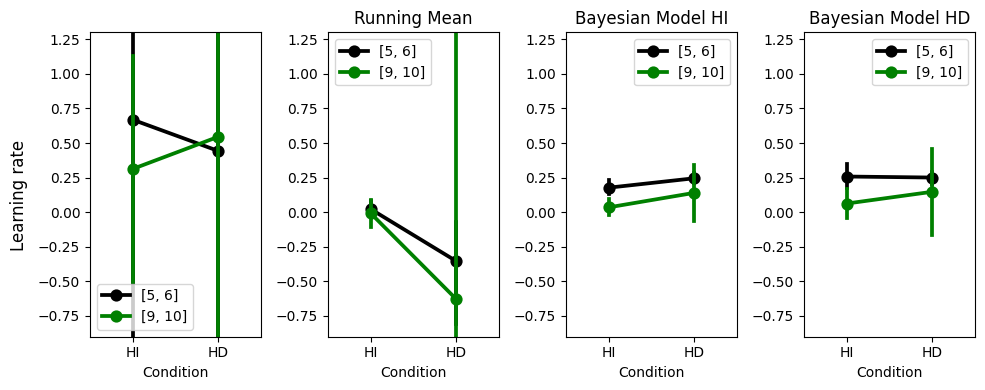

In [39]:
fig, axs = plt.subplots(1,4, figsize=(10,4))

error = "sd"
colors = ["black", "green"]
axs[1].set_title("Running Mean")
sns.pointplot(lr_df_participants_early, x="Condition", y="Learning rate",
              ax=axs[0], label="[5, 6]", color=colors[0], errorbar=error)
sns.pointplot(lr_df_participants_late, x="Condition", y="Learning rate",
              ax=axs[0], label="[9, 10]", color=colors[1], errorbar=error,)


axs[1].set_title("Running Mean")
sns.pointplot(lr_df_mean_early, x="Condition", y="Learning rate", ax=axs[1], label="[5, 6]", color=colors[0])
sns.pointplot(lr_df_mean_late, x="Condition", y="Learning rate",
              ax=axs[1], label="[9, 10]", color=colors[1], errorbar=error)

axs[2].set_title("Bayesian Model HI")
sns.pointplot(lr_df_bayes_early, x="Condition", y="Learning rate", ax=axs[2], label="[5, 6]", color=colors[0])
sns.pointplot(lr_df_bayes_late, x="Condition", y="Learning rate",
              ax=axs[2], label="[9, 10]", color=colors[1], errorbar=error)

axs[3].set_title("Bayesian Model HD")
sns.pointplot(lr_df_bayes_HD_early, x="Condition", y="Learning rate", ax=axs[3], label="[5, 6]", color=colors[0])
sns.pointplot(lr_df_bayes_HD_late, x="Condition", y="Learning rate", ax=axs[3],
              label="[9, 10]", color=colors[1], errorbar=error)

for ax in axs:
  ax.set_ylim(-0.9,1.3)
  ax.set_ylabel("")

fig.supylabel("Learning rate")
fig.tight_layout()

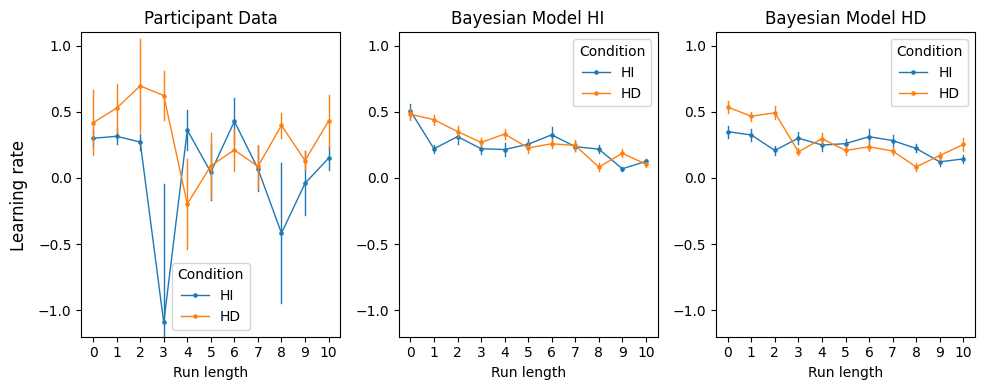

In [53]:
def compare_learning_rates_hi_hd(
    s_ts_hi, x_ts_hi, tau_ts_hi,
    s_ts_hd, x_ts_hd, tau_ts_hd,
    tau_range=(0, 11)
    ):
    """Compare learning rates for HI and HD."""
    assert isinstance(s_ts_hi, np.ndarray), \
        f"s_ts_hi must be a numpy.ndarray, got {type(s_ts_hi)}"

    hi_values = eval_learning_rates(s_ts_hi, x_ts_hi, tau_ts_hi, tau_range=tau_range)
    hd_values = eval_learning_rates(s_ts_hd, x_ts_hd, tau_ts_hd, tau_range=tau_range)

    lr_df = pd.DataFrame({
        "Condition": ["HI"] * len(hi_values) + ["HD"] * len(hd_values),
        "Learning rate": list(hi_values) + list(hd_values),
    })
    lr_df = lr_df.explode("Learning rate")
    lr_df['Run length'] = lr_df.groupby(level=0).cumcount()

    return lr_df.reset_index(drop=True)

# Simulated data
#total_run_length = 40000
#s_ts_hi, x_ts_hi, tau_ts_hi = simulate_snowballs(total_run_length, q_method="HI")
#s_ts_hd, x_ts_hd, tau_ts_hd = simulate_snowballs(total_run_length, q_method="HD")

# Real participant data
tau_ts_hi = hi_df["tau_true"].to_numpy()
s_ts_hi =  hi_df["click_x"].to_numpy()
x_ts_hi = hi_df["x_t"].to_numpy()
tau_ts_hd = hd_df["tau_true"].to_numpy()
s_ts_hd =  hd_df["click_x"].to_numpy()
x_ts_hd = hd_df["x_t"].to_numpy()


# Run models
rolling_mean_hd, rolling_std_hd = rolling_mean_model(x_ts_hd)
rolling_mean_hi, rolling_std_hi = rolling_mean_model(x_ts_hi)

posts, map_est_hd, means_hd, stds_hd = run_ideal_observer_HI(x_ts_hd, q=0.10)
posts, map_est_hi, means_hi, stds_hi = run_ideal_observer_HI(x_ts_hi, q=0.10)

posts_HD_hi, map_est_HD_hi, mean_HD_hi, std_HD_hi = run_ideal_observer_HD(x_ts_hi, lam=1.0, Tmean=10.0, TAU_MAX=25)
posts_HD_hd, map_est_HD_hd, mean_HD_hd, std_HD_hd = run_ideal_observer_HD(x_ts_hd, lam=1.0, Tmean=10.0, TAU_MAX=25)

# Compute learning rates
lr_df_participants = compare_learning_rates_hi_hd(
    s_ts_hi, x_ts_hi, tau_ts_hi,  # TODO: change
    s_ts_hd, x_ts_hd, tau_ts_hd,
    tau_range=(0, 11)
    )
lr_df_mean = compare_learning_rates_hi_hd(
    rolling_mean_hd.to_numpy(), x_ts_hi, tau_ts_hi,
    rolling_mean_hi.to_numpy(), x_ts_hd, tau_ts_hd,
    tau_range=(0, 11)
    )
lr_df_bayes = compare_learning_rates_hi_hd(
    map_est_hi, x_ts_hi, tau_ts_hi,
    map_est_hd, x_ts_hd, tau_ts_hd,
    tau_range=(0, 11)
    )
lr_df_bayes_HD = compare_learning_rates_hi_hd(
    map_est_HD_hi, x_ts_hi, tau_ts_hi,
    map_est_HD_hd, x_ts_hd, tau_ts_hd,
    tau_range=(0, 11)
    )

# Plot
error = "se"
#error = "sd"
fig, axs = plt.subplots(1,3, figsize=(10,4))
axs[0].set_title(f"Participant Data")
sns.pointplot(lr_df_participants, x="Run length", y="Learning rate", hue="Condition",
              linewidth=1, errorbar=error,
              ax=axs[0])

#axs[1].set_title("Runing Mean")
#sns.pointplot(lr_df_mean, x="Run length", y="Learning rate", hue="Condition",
#              linewidth=1, errorbar=error,
#              ax=axs[1])

axs[1].set_title("Bayesian Model HI")
sns.pointplot(lr_df_bayes, x="Run length", y="Learning rate", hue="Condition",
              linewidth=1, errorbar=error,
              ax=axs[1])

axs[2].set_title("Bayesian Model HD")
sns.pointplot(lr_df_bayes_HD, x="Run length", y="Learning rate", hue="Condition",
              linewidth=1, errorbar=error,
              ax=axs[2])

fig.supylabel("Learning rate")
for ax in axs:
  ax.set_ylabel("")
  ax.set_ylim([-1.2, 1.1])

fig.tight_layout()


In [ ]:
# Simulated data
total_run_length = 40000
s_ts_hi, x_ts_hi, tau_ts_hi = simulate_snowballs(total_run_length, q_method="HI")
s_ts_hd, x_ts_hd, tau_ts_hd = simulate_snowballs(total_run_length, q_method="HD")


posts, map_est_hd, means_hd, stds_hd = run_ideal_observer_HI(x_ts_hd, q=0.10)
posts, map_est_hi, means_hi, stds_hi = run_ideal_observer_HI(x_ts_hi, q=0.10)

posts_HD_hi, map_est_HD_hi, mean_HD_hi, std_HD_hi = run_ideal_observer_HD(x_ts_hi, lam=1.0, Tmean=10.0, TAU_MAX=25)
posts_HD_hd, map_est_HD_hd, mean_HD_hd, std_HD_hd = run_ideal_observer_HD(x_ts_hd, lam=1.0, Tmean=10.0, TAU_MAX=25)

# Compute learning rates

lr_df_bayes = compare_learning_rates_hi_hd(
    map_est_hi, x_ts_hi, tau_ts_hi,
    map_est_hd, x_ts_hd, tau_ts_hd,
    tau_range=(0, 11)
    )
lr_df_bayes_HD = compare_learning_rates_hi_hd(
    map_est_HD_hi, x_ts_hi, tau_ts_hi,
    map_est_HD_hd, x_ts_hd, tau_ts_hd,
    tau_range=(0, 11)
    )

# Plot
error = "se"
#error = "sd"
fig, axs = plt.subplots(1,2, figsize=(10,4))


axs[1].set_title("Bayesian Model HI")
sns.pointplot(lr_df_bayes, x="Run length", y="Learning rate", hue="Condition",
              linewidth=1, errorbar=error,
              ax=axs[0])

axs[2].set_title("Bayesian Model HD")
sns.pointplot(lr_df_bayes_HD, x="Run length", y="Learning rate", hue="Condition",
              linewidth=1, errorbar=error,
              ax=axs[1])

fig.supylabel("Learning rate")
for ax in axs:
  ax.set_ylabel("")
  ax.set_ylim([-1.2, 1.1])

fig.tight_layout()
